#### Import the Dataset Into Pytorch

Use the `torchvision.datasets.ImageFolder` class to load the dataset.

In [265]:
from torchvision.datasets import ImageFolder

In [266]:
data_dir = 'C:\\Users\\DexTerMtor\\Desktop\\Flower-Species-Classification\\flowers'
dataset = ImageFolder(data_dir)

In [267]:
len(dataset)

4317

In [268]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263>, 0)

In [269]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [270]:
import matplotlib.pyplot as plt
%matplotlib inline

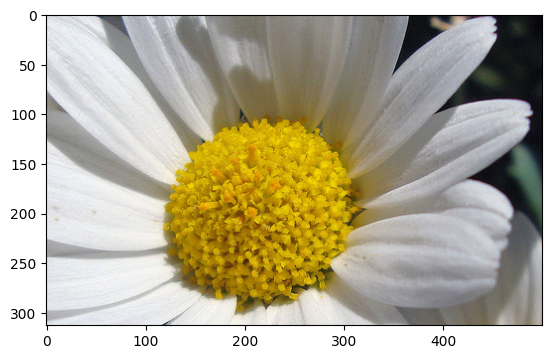

In [271]:
img, lable = dataset[1]
plt.imshow(img)

#### Data Augmentation and Normalization for Training

here we will croping and fixing the size of the image to 224x224 and then normalizing the image.

In [272]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

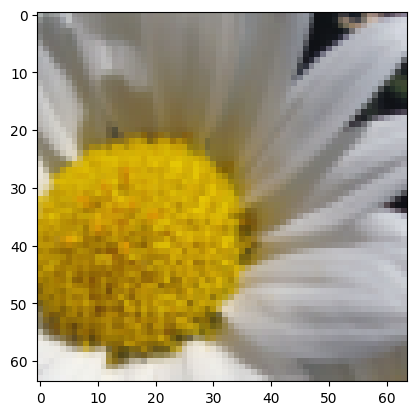

In [273]:
img, lable = dataset[1]
plt.imshow(img.permute((1,2,0)))

In [274]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [275]:
from torch.utils.data import random_split, DataLoader

train_data, valid_data = random_split(dataset, [ train_size, val_size])
len(train_data), len(valid_data)

(3886, 431)

In [276]:
batch_size = 128

train_dl = DataLoader(train_data, 
                      batch_size,
                      shuffle=True,
                      num_workers = 4,
                      pin_memory=True)

valid_dl = DataLoader(valid_data,
                      batch_size,
                      num_workers=4,
                      pin_memory=True)

### making grid view for the training data of images

In [277]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6)) 
        ax.set_xticks([]) 
        ax.set_yticks([])  
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))  
        plt.show()
        break

In [278]:
show_batch(train_dl)

#### GPU Utility Functions and Classes for Training and Evaluation

In [ ]:
import torch 
def get_default_device():
     """Pick GPU if available, else CPU"""
     if torch.cuda.is_available():
          return torch.device('cuda')
     else:
          return torch.device('cpu')

def to_device(data, device):
     """Move tensor(s) to choosen device"""
     if isinstance(data, (list,tuple)):
          return [to_device(x, device) for x in data]
     return data.to(device, non_blocking=True)

class DeviceDataLoader():
     """Wrap a dataloader to move data to device"""
     def __init__(self, dl, device):
          self.dl = dl
          self.device = device
     
     def __iter__(self):
          """Yield a batch of data after moving it to device"""
          for b in self.dl:
               yield to_device(b, self.device)
               
     def __len__(self):
          """Number of batches"""

          return len(self.dl)

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

#### loading traininig data and testing data on the gpu using dataloader

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#### Model and Training the utilities

In [ ]:
import torch.nn as nn

class ImageClassificationBase(nn.Module):
     """Calculate loss for a batch of training data"""
     def training_step(self, batch):
          images, labels = batch 
          out = self(images)                  # Generate predictions
          loss = F.cross_entropy(out, labels) # Calculate loss
          return loss
     
     """Calculate loss & accuracy for a batch of validation data"""
     def validation_step(self, batch):
          images, labels = batch 
          out = self(images)                    # Generate predictions
          loss = F.cross_entropy(out, labels)   # Calculate loss
          acc = accuracy(out, labels)           # Calculate accuracy
          return {'val_loss': loss.detach(), 'val_acc': acc}
          
     def validation_epoch_end(self, outputs):
          batch_losses = [x['val_loss'] for x in outputs]
          epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
          batch_accs = [x['val_acc'] for x in outputs]
          epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
          return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
     
     def epoch_end(self, epoch, result):
          print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
     """Evaluate the modal's performance ont the validation set"""
     model.eval()
     outputs = [model.validation_step(batch) for batch in val_loader]
     return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
     history = []
     optimizer = opt_func(model.parameters(), lr)
     for epoch in range(epochs):
          # Training Phase 
          model.train()
          train_losses = []
          for batch in train_loader:
               loss = model.training_step(batch)
               train_losses.append(loss)
               loss.backward()
               optimizer.step()
               optimizer.zero_grad()
          # Validation phase
          result = evaluate(model, val_loader)
          result['train_loss'] = torch.stack(train_losses).mean().item()
          model.epoch_end(epoch, result)
          history.append(result)
     return history

#### Defining the Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
     def __init__(self, in_channels, num_classes):
          super().__init__()
          #Input: 128 x 3 x 64 x 64
          self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
          self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
          self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                    conv_block(128, 128)) # 128 x 128 x 32 x 32
          
          self.conv3 = conv_block(128, 256, pool=True) # 128 x 128 x 16 x 16
          self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
          self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))# 128 x 512 x 8 x 8
          
          self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                             nn.Flatten(), # 128 x 512
                                             nn.Dropout(0.2),
                                             nn.Linear(512, num_classes))
          
     def forward(self, xb):
          out = self.conv1(xb)
          out = self.conv2(out)
          out = self.res1(out) + out
          out = self.conv3(out)
          out = self.conv4(out)
          out = self.res2(out) + out
          out = self.classifier(out)
          return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model to check the output shape.

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
     images, lables = batch
     print('images.shape', images.shape)
     print('images.device',images.device)
     preds = model(images)
     print('preds.shape', preds.shape)
     print(preds)
     break

images.shape torch.Size([64, 3, 64, 64])
images.device cuda:0


C:\Users\DexTerMtor\.conda\envs\py310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 54.00 MiB. GPU  (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\DexTerMtor\.conda\envs\py310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB. GPU  (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\DexTerMtor\.conda\envs\py310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 86.00 MiB. GPU  (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\DexTerMtor\.conda\envs\py310\lib\site-packa

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 